# Import Libraries and Data

In [1]:
# import relevant modeling + other libraries
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB, CategoricalNB, ComplementNB
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
import statsmodels.api as sm
import warnings
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
# open data
with open('data/full_data.pkl','rb') as f:
    df = pkl.load(f)

# Select the features and target for our modeling

In [38]:
# these are the features that will be used to build our model.
# most are nominal/dummied data (ie which borough or direction a delay occured in)
# other are interval (ie temperature and wind speed)
features = ['bronx','brooklyn', 'manhattan', 'queens', 'direction_bronx', 'direction_brooklyn', 'direction_manhattan',
            'direction_queens', 'direction_both', 'direction_north', 'direction_south',
            'mon', 'tue', 'wed', 'th', 'fri', 'weekend','holiday','rush_hour', 
            'max_temp', 'avg_temp', 'min_temp', 'avg_wind_spd', 'fastest_wind_spd','major_conditions',
             'minor_conditions', 'neutral_conditions', 'clear_conditions', 'prcp', 'snowfall', 'snowfall_depth',]

In [5]:
# creating the target column
df.insert(0,'delayed_all',0)
ind_both = df.loc[(df['delayed_div_a']==1)&(df['delayed_div_b']==1)].index
ind_a = df.loc[(df['delayed_div_a']==1)&~((df['delayed_div_a']==1)&(df['delayed_div_b']==1))].index
ind_b = df.loc[(df['delayed_div_b']==1)&~((df['delayed_div_a']==1)&(df['delayed_div_b']==1))].index
df.loc[ind_a,'delayed_all'] = 0
df.loc[ind_b,'delayed_all'] = 1
df.loc[ind_both,'delayed_all'] = 2
df['delayed_all'].value_counts()

In [51]:
# initiate a list that we'll add the model names and scores to
models_and_scores = []

# LogReg

In [39]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('lr', LogisticRegression(C=0.2, solver='saga'))])


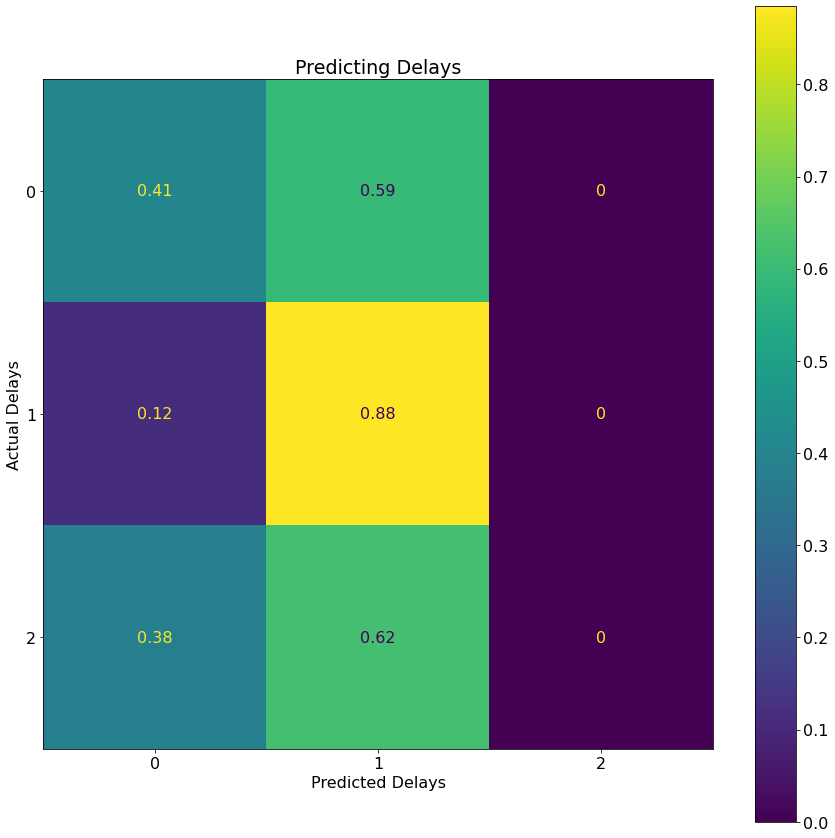


Overall Accuracy: 69.07%,
F1 Score: 69.07%



In [40]:
# I ran this before, took a lot of RAM, best solver was saga...
lr = LogisticRegression()
lr_params = {'lr__C':[.2,.5,.7,.9,1],
            'lr__solver':['saga'],
            'lr__penalty':['l2','none']}
pipe_lr = Pipeline(steps=[('lr',LogisticRegression())])

gsv_lr = GridSearchCV(pipe_lr,lr_params,scoring='homogeneity_score')

gsv_lr.fit(X_train,y_train)

y_pred = gsv_lr.best_estimator_.predict(X_test)

print(gsv_lr.best_estimator_)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gsv_lr,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_lr = f"LogReg Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_lr = f"LogReg F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_lr}%,
F1 Score: {f1_lr}%
""")

models_and_scores.append(acc_lr, f1_lr)

# Clustering

## KNN Classification

In [9]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('knn',
                 KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                                      weights='distance'))])


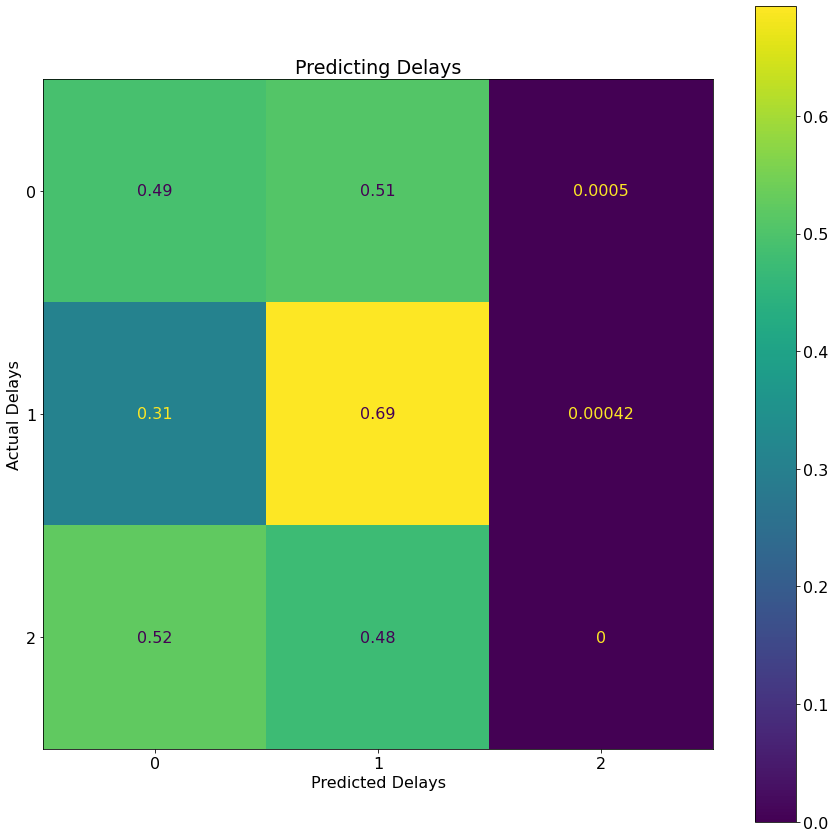


Overall Accuracy: 61.1%,
F1 Score: 61.1%



In [11]:
knn_params = {'knn__n_neighbors':[3,5,7],
             'knn__weights':['uniform','distance'],
             'knn__algorithm':['auto','ball_tree','kd_tree','brute'],
             'knn__metric':['minkowski','euclidean','manhattan']}
pipe_knn = Pipeline(steps=[('knn',KNeighborsClassifier())])

gsv_knn = GridSearchCV(pipe_knn,knn_params,scoring='homogeneity_score')

gsv_knn.fit(X_train,y_train)

y_pred = gsv_knn.best_estimator_.predict(X_test)

print(gsv_knn.best_estimator_)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gsv_knn,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_knn = f"KNN Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_knn = f"KNN F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_knn}%,
F1 Score: {f1_knn}%
""")

models_and_scores.append(acc_knn, f1_knn)

## KMeans Clustering

In [12]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
kmeans_params = {'km__n_clusters':[3],
                 'km__algorithm':['auto','full','elkan']}
pipe_km = Pipeline(steps=[('km',KMeans())])

gsv_km = GridSearchCV(pipe_km,kmeans_params,scoring='homogeneity_score')

gsv_km.fit(X_train, y_train)

y_pred = gsv_km.best_estimator_.predict(X_test)

print(gsv_km.best_estimator_)

acc_km = f"KMeans Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_km = f"KMeans F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_km}%,
F1 Score: {f1_km}%
""")

models_and_scores.append(acc_km, f1_km)

Pipeline(steps=[('km', KMeans(algorithm='elkan', n_clusters=3))])

Overall Accuracy: KMeans Acc: 35.58%%,
F1 Score: KMeans F1: 35.58%%



NameError: name 'models_and_scores' is not defined

# Naive Bayes

## Gaussian NB

In [15]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

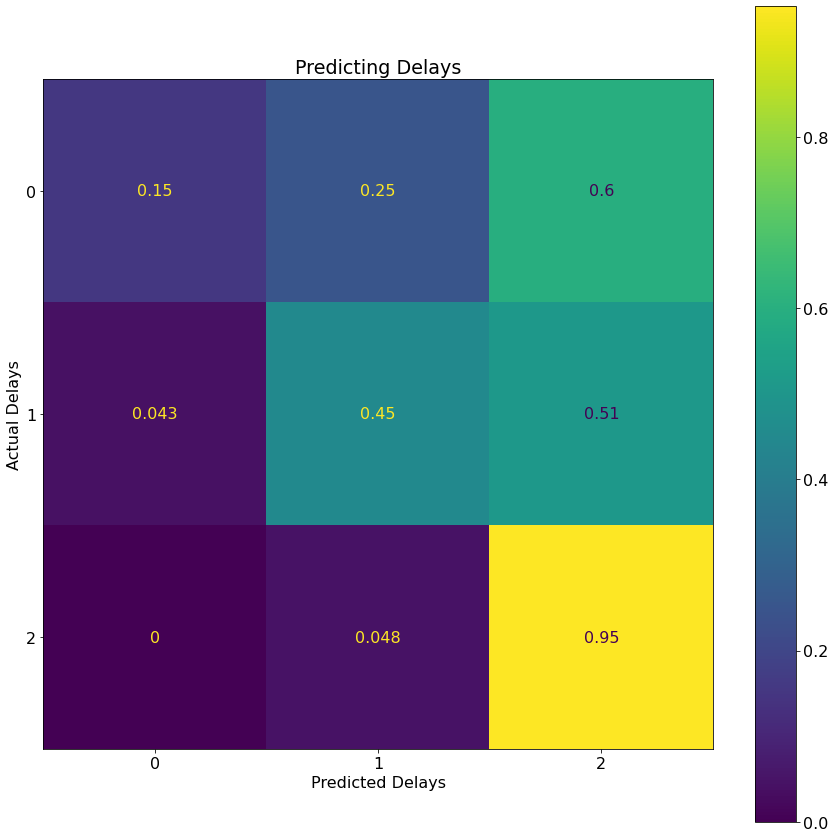


Overall Accuracy: 33.15%,
F1 Score: 43.36%



In [16]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gnb,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_gnb = f"GNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_gnb = f"GNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_gnb}%,
F1 Score: {f1_gnb}%
""")

models_and_scores.append(acc_gnb, f1_gnb)

## Complement NB

In [17]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('cnb', ComplementNB(alpha=1, norm='True'))])


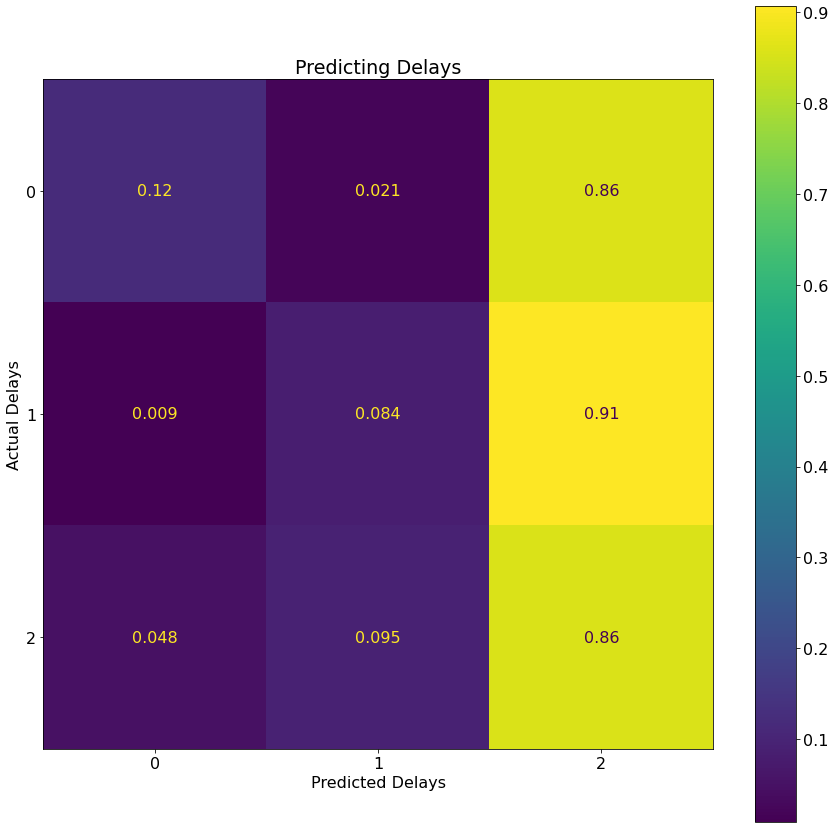


Overall Accuracy: 9.9%,
F1 Score: 9.9%



In [18]:
cnb_params = {'cnb__alpha':[1,.9,.5,.2,0],
             'cnb__norm':['True','False']}
pipe_cnb = Pipeline(steps=[('cnb',ComplementNB())])

gsv_cnb = GridSearchCV(pipe_cnb,cnb_params,scoring='homogeneity_score')

gsv_cnb.fit(X_train,y_train)

y_pred = gsv_cnb.best_estimator_.predict(X_test)

print(gsv_cnb.best_estimator_)

y_pred = gsv_cnb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_cnb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_cnb = f"CNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_cnb = f"CNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_cnb}%,
F1 Score: {f1_cnb}%
""")

models_and_scores.append(acc_cnb, f1_cnb)

## Multinomial NB

In [19]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('mnb', MultinomialNB(alpha=0, fit_prior='True'))])


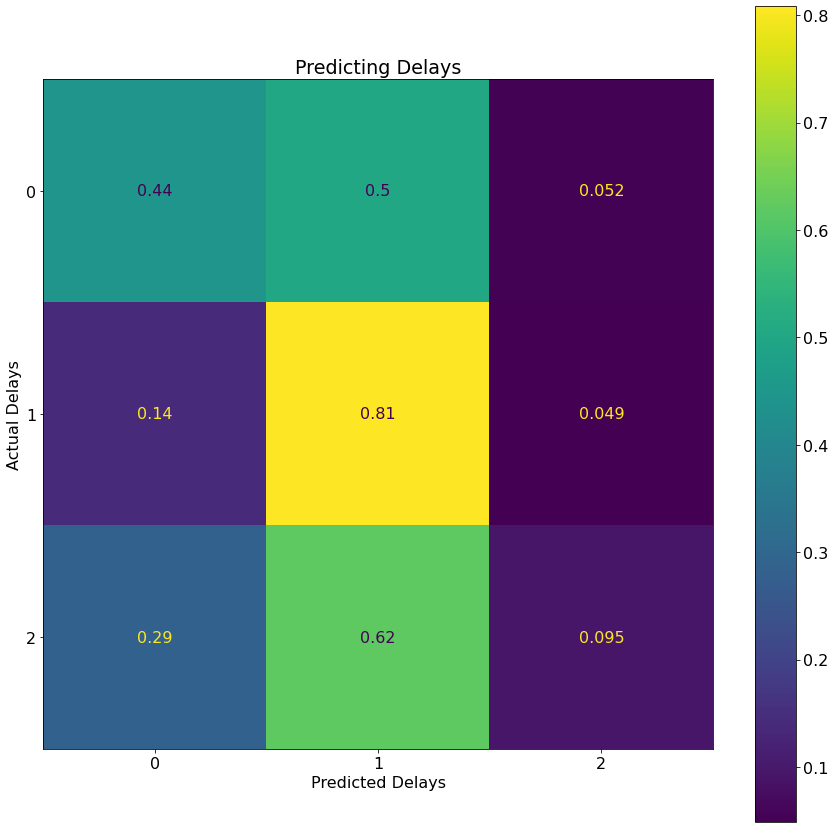


Overall Accuracy: 66.05%,
F1 Score: 66.4%



In [20]:
mnb_params = {'mnb__alpha':[1,.9,.5,.2,0],
             'mnb__fit_prior':['True','False']}
pipe_mnb = Pipeline(steps=[('mnb',MultinomialNB())])

gsv_mnb = GridSearchCV(pipe_mnb,mnb_params,scoring='homogeneity_score')

gsv_mnb.fit(X_train,y_train)

y_pred = gsv_mnb.best_estimator_.predict(X_test)

print(gsv_mnb.best_estimator_)

y_pred = gsv_mnb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_mnb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_mnb = f"MNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_mnb = f"MNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_mnb}%,
F1 Score: {f1_mnb}%
""")

models_and_scores.append(acc_mnb, f1_mnb)

## Bernoulli NB

In [41]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [59]:
test = {}

In [64]:
test.update({"BNB":acc_bnb})
test.update({"BNB":f1_bnb})

In [65]:
test

{'BNB': 'BNB F1: 67.88%'}

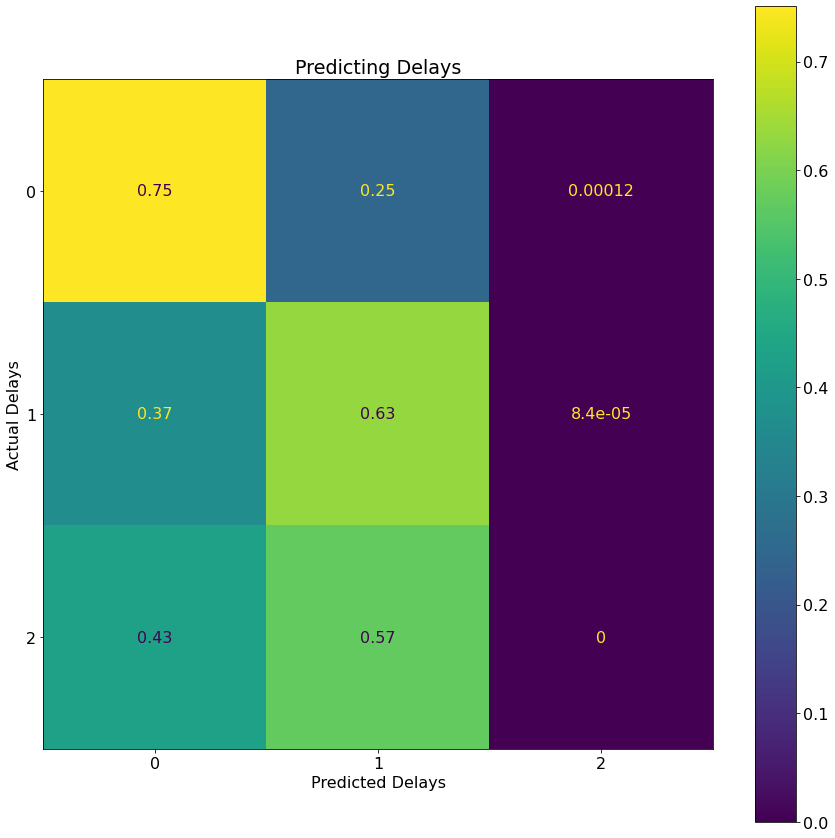

Pipeline(steps=[('bnb', BernoulliNB(alpha=0.9))])

Overall Accuracy: BNB Acc: 67.88%%,
F1 Score: BNB F1: 67.88%%



In [56]:
bnb_params = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe_bnb = Pipeline(steps=[('bnb',BernoulliNB())])

gsv_bnb = GridSearchCV(pipe_bnb, bnb_params,scoring='homogeneity_score')

gsv_bnb.fit(X_train, y_train)
y_pred = gsv_bnb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_bnb.best_estimator_)

acc_bnb = f"BNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_bnb = f"BNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_bnb}%,
F1 Score: {f1_bnb}%
""")

models_and_scores.append(acc_bnb)
models_and_scores.append(f1_bnb)

## Categorical NB

In [52]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

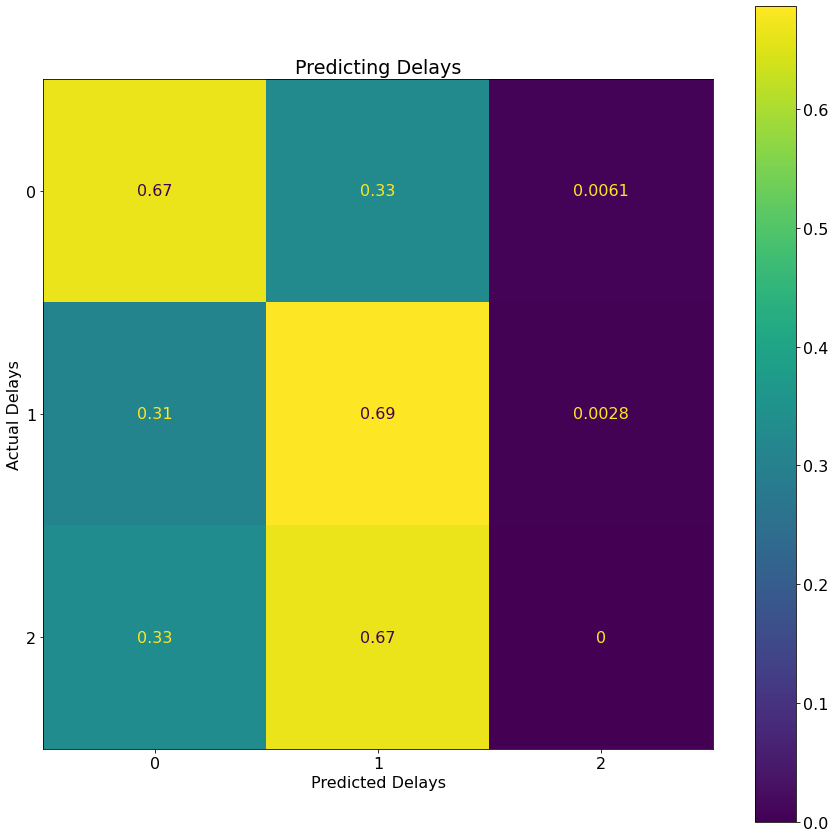

Pipeline(steps=[('canb', CategoricalNB(alpha=0.2, fit_prior='True'))])

Overall Accuracy: CaNB Acc: 67.75%%,
F1 Score: CaNB F1: 67.75%%



In [55]:
canb_params = {'canb__alpha':[1,.9,.5,.2,0],
              'canb__fit_prior':['True','False']
              }
pipe_canb = Pipeline(steps=[('canb',CategoricalNB())])

gsv_canb = GridSearchCV(pipe_canb, canb_params,scoring='homogeneity_score')

gsv_canb.fit(X_train, y_train)
y_pred = gsv_canb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_canb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_canb.best_estimator_)

acc_canb = f"CaNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_canb = f"CaNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_canb}%,
F1 Score: {f1_canb}%
""")

models_and_scores.append(acc_canb)
models_and_scores.append(f1_canb)

# XGBoost

In [27]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
xg_cl = xgb.XGBClassifier()
xg_cl.fit(X_train,y_train)
train_score = f"XGB Train Score: {round(xg_cl.score(X_train, y_train),4)}"
test_score = f"XGB Test Score: {round(xg_cl.score(X_test,y_test),4)}"

print(train_score, '\\', test_score)

models_and_scores.append()

[21:12:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7526095684175309 \ 0.6950870677974608


# PCA

In [29]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.91339084 0.06106079 0.01216448 0.00309741 0.00297438]
[8493.87055733 2196.13242456  980.22132701  494.62537926  484.70273746]


# Classification/Decision Tree

## Gradient Boost

In [36]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
clf_params = {'clf__loss':['deviance','exponential'],
              'clf__learning_rate':[.1,.5,.9],
              'clf__n_estimators':[100,200],
              'clf__criterion':['friedman_mse','squared_error','mse','mae']
              }
pipe_clf = Pipeline(steps=[('clf',GradientBoostingClassifier())])

gsv_clf = GridSearchCV(pipe_clf, clf_params,scoring='homogeneity_score')

gsv_clf.fit(X_train, y_train)
y_pred = gsv_clf.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_clf, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_clf.best_estimator_)

acc_grb = f"GrB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_grb = f"GrB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_grb}%,
F1 Score: {f1_grb}%
""")

models_and_scores.append(acc_grb, f1_grb)

KeyboardInterrupt: 

## Decision Tree

In [ ]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
clf_params = {'clf__criterion':['gini','entropy'],
              'clf__max_features':['auto','sqrt','log2']
              }
pipe_clf = Pipeline(steps=[('clf',DecisionTreeClassifier())])

gsv_clf = GridSearchCV(pipe_clf, clf_params,scoring='homogeneity_score')

gsv_clf.fit(X_train, y_train)
y_pred = gsv_clf.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_clf, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_clf.best_estimator_)

acc_dt = f"DT Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_dt = f"DT F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_dt}%,
F1 Score: {f1_dt}%
""")

models_and_scores.append(acc_dt, f1_dt)

## Random Forest

In [ ]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
clf_params = {'clf__n_estimators':[100,200],
              'clf__criterion':['gini','entropy'],
              'clf__max_features':['auto','sqrt','log2']
              }
pipe_clf = Pipeline(steps=[('clf',RandomForestClassifier())])

gsv_clf = GridSearchCV(pipe_clf, clf_params,scoring='homogeneity_score')

gsv_clf.fit(X_train, y_train)
y_pred = gsv_clf.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_clf, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_clf.best_estimator_)

acc_rf = f"RF Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_rf = f"RF F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_rf}%,
F1 Score: {f1_rf}%
""")

models_and_scores.append(acc_rf, f1_rf)

# Individual Lines

## Div A Trains

In [14]:
X = df[features]
y = df['delayed_div_a']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

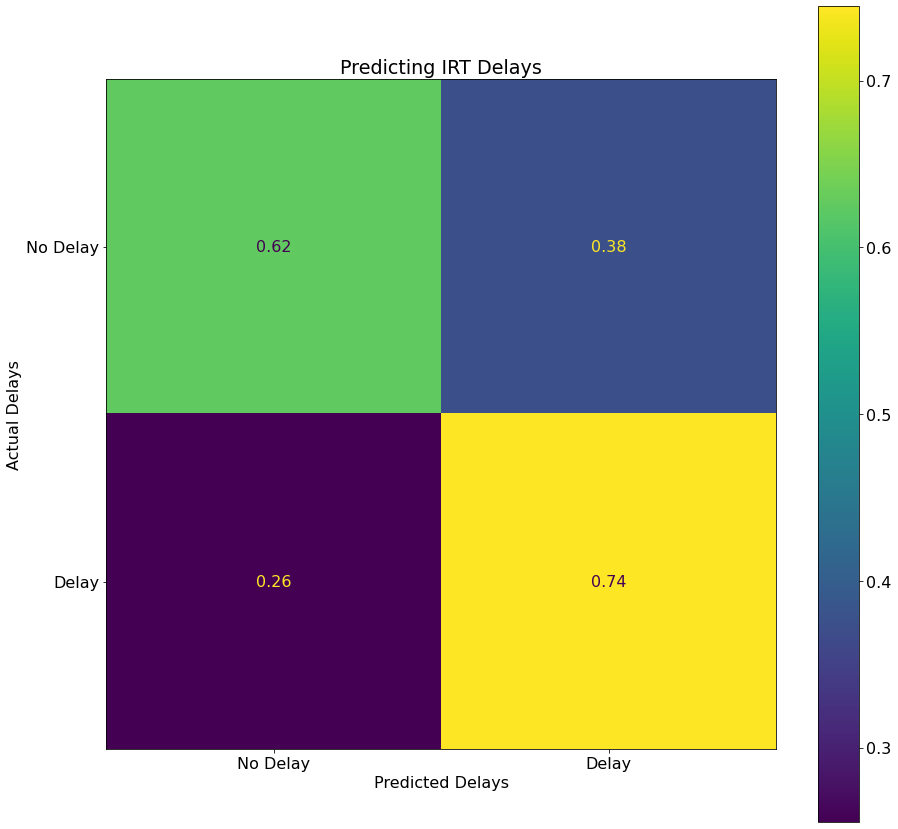

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])

Overall Accuracy: 68.92%,
F1 Score: 63.28%

Overall SMOTE Accuracy: 67.34%,
SMOTE F1 Score: 64.84%


In [15]:
bnb_params = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe_bnb = Pipeline(steps=[('bnb',BernoulliNB())])

gsv_bnb = GridSearchCV(pipe_bnb, bnb_params,scoring='f1')
gsv_bnb_sm = GridSearchCV(pipe_bnb, bnb_params,scoring='f1')

gsv_bnb.fit(X_train, y_train)
gsv_bnb_sm.fit(X_train_resampled, y_train_resampled)

y_pred = gsv_bnb.best_estimator_.predict(X_test)
y_pred_sm = gsv_bnb_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

# checking the best estimators from gsv
print(gsv_bnb_sm.best_estimator_)

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

# type of disruptions

passenger_disruption

station_integrity_disruption

mechanical_and_track_disruption

train_disruption

weather_disruption

signal_disruption

switch_disruption